## Problem Statement

In [ ]:
import tensorflow as tf
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from helper_functions import view_random_image, preprocess_image, pred_and_plot
from helper_functions import create_tensorboard_callbacks
from helper_functions import data_augmentation, checkpoint_callback, plot_loss_curves, compare_history
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Observing our dataset¶

In [14]:
# Checking and listing the files and sub_folders in our data(image) folder
for folder_path, folder_name, filename in os.walk ("train/"):
    print (f"there are {len (folder_name)} folders and {len (filename)} images in '{folder_path}'.")

there are 18 folders and 0 images in 'train/'.
there are 0 folders and 255 images in 'train/Abacha and Ugba(african salad)'.
there are 0 folders and 348 images in 'train/Akara and Eko'.
there are 0 folders and 361 images in 'train/Amala and Gbegiri- Ewedu'.
there are 0 folders and 334 images in 'train/Asaro'.
there are 0 folders and 233 images in 'train/Boli(bole)'.
there are 0 folders and 300 images in 'train/Chin Chin'.
there are 0 folders and 380 images in 'train/Egusi Soup'.
there are 0 folders and 207 images in 'train/Ewa-Agoyin'.
there are 0 folders and 439 images in 'train/Fried Plantains (dodo)'.
there are 0 folders and 480 images in 'train/Jollof Rice'.
there are 0 folders and 255 images in 'train/Meat-pie'.
there are 0 folders and 318 images in 'train/Moin-Moin'.
there are 0 folders and 255 images in 'train/Nkwobi'.
there are 0 folders and 453 images in 'train/Okro Soup'.
there are 0 folders and 433 images in 'train/Pepper Soup'.
there are 0 folders and 308 images in 'train/P

In [15]:
# Checking our food classes
class_names = os.listdir ("nigeria_foods_30_percent/train")
class_names

['Abacha and Ugba(african salad)',
 'Akara and Eko',
 'Amala and Gbegiri- Ewedu',
 'Asaro',
 'Boli(bole)',
 'Chin Chin',
 'Egusi Soup',
 'Ewa-Agoyin',
 'Fried Plantains (dodo)',
 'Jollof Rice',
 'Meat-pie',
 'Moin-Moin',
 'Nkwobi',
 'Okro Soup',
 'Pepper Soup',
 'Puff-Puff',
 'Suya',
 'Vegetable Soup']

In [5]:
# creating train and test(valid) directory path
train_dir = "train"
valid_dir = "test"

Image: ['images77.jpg', 'images144.jpg', 'images543.jpg']




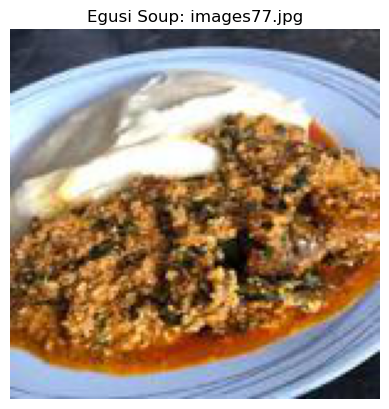

Image shape: (150, 150, 3)




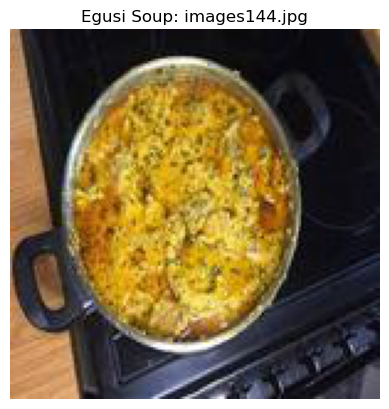

Image shape: (150, 150, 3)




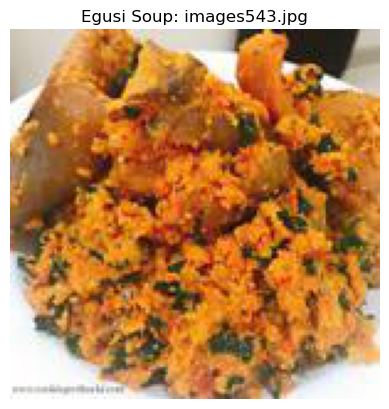

Image shape: (150, 150, 3)




In [6]:
# Viewing images from random classes
view_random_image (train_dir, "Egusi Soup", 3)

In [36]:
# Importing, reshapeing and converting our data(images) into batches
train_data = image_dataset_from_directory (directory = train_dir,
                                           image_size = (224, 224),
                                           label_mode = "categorical",
                                           batch_size = 32,
                                           shuffle = True)

valid_data = image_dataset_from_directory (directory = valid_dir,
                                           image_size = (224, 224),
                                           label_mode = "categorical",
                                           batch_size = 32,
                                           shuffle = False)   # don't shuffle test data for prediction analysis

Found 6106 files belonging to 18 classes.
Found 1491 files belonging to 18 classes.


In [32]:
train_data_num = len (train_data)
valid_data_num = len (valid_data)

In [33]:
# Repeat the datasets indefinitely to prevent running out of data
train_data = train_data.repeat()
valid_data = valid_data.repeat()

## creating a ModelCheckpoint callback
The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. this is useful so we can come and start where we left off

In [20]:
# set checkpoint path
checkpoint_path = "nigeria_foods_100_percent_checkpoints/functional_100_percent_efficientNetB6_1.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint (filepath = checkpoint_path,
                                                          save_weights_only = True,
                                                          save_best_only = True,
                                                          monitor = "val_accuracy",
                                                          verbose = 1)

## Adding data augmentation into our model
To add data augmentation into our model we use the layers inside our ensorflow.keras.layers

In [21]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth

data_augmentation_layer = tf.keras.Sequential ([RandomFlip ("horizontal"),
                                               RandomRotation (0.3),
                                               RandomZoom (0.2),
                                               RandomHeight (0.3),
                                               RandomWidth (0.4)
                                               ])

### Model_0: 
**Building our EfficientNetB1 Feature Extraction (with 1 Dense layer 320 unit) without Data Augmentation**

In [29]:
# Setup the input shape, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB6 (include_top = False)
base_model.trainable = False

# create the input layer
input_layer = tf.keras.layers.Input (shape = input_shape, name = "Input_layer")

# Adding Data augmentation as a layer
x = data_augmentation (input_layer)

# Give base_model the inputs (after augmetation) and don't train it
x = base_model (x, training = False)

# Pool output features of the base model (to get a feature vector)
x = tf.keras.layers.GlobalAveragePooling2D (name = "global_average_pooling_layer") (x)
x = tf.keras.layers.Dropout (0.5) (x)

# creating the output Dense classifier layer
x = tf.keras.layers.Dense (1024, activation = "relu", name = "fully_connected_layer_1") (x)
x = tf.keras.layers.Dense (512, activation = "relu", name = "fully_connected_layer_2") (x)
output_layer = tf.keras.layers.Dense (18, activation = "softmax", name = "output_layer") (x)

# creating our model
model_0 = tf.keras.Model (input_layer, output_layer)
model_0.summary ()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation_layer (Sequential) │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb6 (Functional)          │ (None, None, None, 2304)    │      40,960,143 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 2304)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_layer_1 (Dense)      │ (None, 1024)                │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_layer_2 (Dense)      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 18)                  │           9,234 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,854,497 (167.29 MB)

 Trainable params: 2,894,354 (11.04 MB)

 Non-trainable params: 40,960,143 (156.25 MB)

### Compiling and Fitting our model_0

In [34]:
# Compile the model with learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler (lambda epoch: initial_learning_rate * 0.1**(epoch // 10))

# Define the EarlyStopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',        # Metric to be monitored
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    min_delta=0.01,           # Minimum change to qualify as an improvement
    mode='max',                # Whether to minimize or maximize the monitored metric
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored metric
)
                 
# compiling our model
model_0.compile (loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam (), metrics = ["accuracy"])

# fitting our model and validate with 15% valid data
history_0 = model_0.fit (train_data, steps_per_epoch = train_data_num, epochs = 20,
                         validation_data = valid_data, validation_steps = int (valid_data_num * 0.25),
                         callbacks = [create_tensorboard_callbacks (dir_name = "nigeria_foods_30_percent_tensorboard",
                                                                    experiment_name = "functional_30_percent_efficientNetB0_0"),
                                     checkpoint_callbacks, lr_schedule, early_stopping_cb])

Saving TensorBoard Log files to: nigeria_foods_30_percent_tensorboard/functional_30_percent_efficientNetB0_0/  20240708-142139
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5496 - loss: 1.3978
Epoch 1: val_accuracy did not improve from 0.76420
191/191 ━━━━━━━━━━━━━━━━━━━━ 896s 4s/step - accuracy: 0.5497 - loss: 1.3976 - val_accuracy: 0.7045 - val_loss: 0.8267 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6002 - loss: 1.2275
Epoch 2: val_accuracy did not improve from 0.76420
191/191 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.6002 - loss: 1.2274 - val_accuracy: 0.6165 - val_loss: 1.1861 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6300 - loss: 1.1604
Epoch 3: val_accuracy improved from 0.76420 to 0.76989, saving model to nigeria_foods_100_percent_checkpoints/functional_100_percent_efficientNetB6_1.weights.h5
191/191 ━━━━━━━━━━━━━━━━━━━━ 853s 4s/step - accuracy: 0.6301 - loss: 1.

In [39]:
# evaluating model_0 on the complete validation data 72(no_aug) 
metrics = model_0.evaluate (train_data)
print (f"models accuracy: {metrics[1]} \nmodels loss: {metrics[0]}")

191/191 ━━━━━━━━━━━━━━━━━━━━ 751s 4s/step - accuracy: 0.8935 - loss: 0.3415
models accuracy: 0.8927284479141235 
models loss: 0.339490681886673


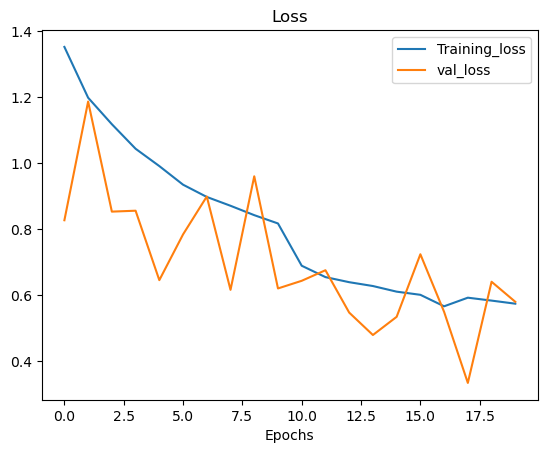

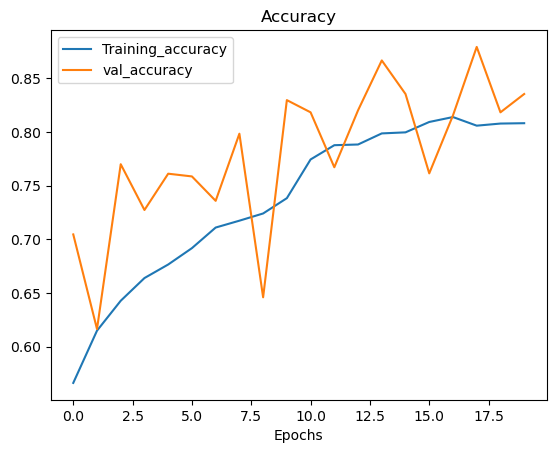

In [37]:
# Plotting loss curves
plot_loss_curves (history_0)

### Making predictions with our trained model (model_0)

In [82]:
preds_prob = model_0.predict (valid_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
number of predicted classes for sample 10: (18,)
class_number of sample 10 is: 0
class_name of sample 10 is: Abacha and Ugba(african salad)


In [83]:
print (f"number of predicted classes for sample 10: {preds_prob[10].shape}")
print (f"class_number of sample 10 is: {preds_prob[10].argmax ()}")
print (f"class_name of sample 10 is: {class_names [preds_prob[10].argmax ()]}")

number of predicted classes for sample 10: (18,)
class_number of sample 10 is: 0
class_name of sample 10 is: Abacha and Ugba(african salad)


In [89]:
# Getting our prediction labels and probabilities for all the images
y_pred = preds_prob.argmax (axis = 1)
y_pred

array([14,  9,  0, ...,  6, 17, 13], dtype=int64)

**Now we have got a prediction arrays of all of our model's prediction, to evaluate them, we need to compare them to the original labels**

In [99]:
# to get our original test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in valid_data.unbatch ():
    y_label = labels.numpy ().argmax ()# currently test labels looks like: [0, 0, 0, 0, 1, ....] we want the index where the "1" occurs
    y_labels.append (y_label)
y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [100]:
# Checking the accuracy_score using sklearn metrics
accuracy_score (y_labels, y_pred)

0.7873910127431254

## Making predictions on test images
To make prdictions on custom images our custom images must be in the same format as our train_images

**let's create a function to visualise our images their target labels and model's predictions**


**what our function is going to do**
- load a few random images from the test dataset
- make predictions on the loaded images
- plot the original image(s) along the model's prediction, prediction probability and truth label

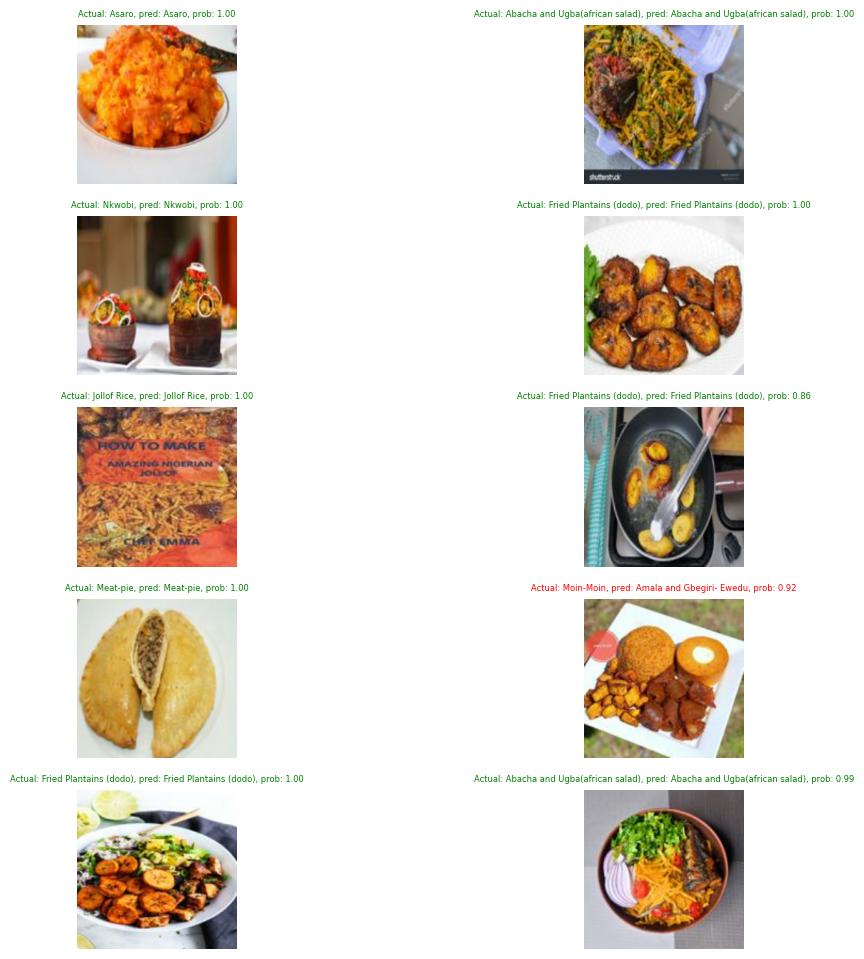

In [161]:
##### Creating a function that Process our custom images
def process_image (img_path, img_shape = 224, scale = False):
    """
    a function that reads and process our images
    """
    img = tf.io.read_file (img_path)
    img = tf.image.decode_image (img, channels = 3)
    img = tf.image.resize (img, (img_shape, img_shape))

    # Scale? yes/no
    if scale:
        return img / 255.
    else:
        return img  # don't need to rescale images for EfficientNet model

# plotting our models prediction
plt.figure (figsize = (12, 12))
for i in range (10):
    # choose a random image from a random class
    class_name = random.choice (class_names)
    filename = random.choice (os.listdir (valid_dir + "/" + class_name))
    img_path = f"{valid_dir}/{class_name}/{filename}"

    # load the image and make predictions
    img = process_image (img_path)
    pred_prob = model_2.predict (tf.expand_dims (img, axis = 0), verbose = 0) # get prediction probability array
    pred_class = class_names[pred_prob.argmax ()] # get index of highest prediction
    
    # plot the images
    plt.subplot (5, 2, i+1)
    plt.imshow (img/255)
    if class_name == pred_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title (f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max ():.2f}", fontsize = 6, c = title_color)
    plt.axis (False)

### Model_1: 
**Building our EfficientNetB1 Feature Extraction (with 3 Dense layer 320-200-80 unit) with Data Augmentation**

In [36]:
# Setup the input shape, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB1 (include_top = False)
base_model.trainable = False

# Create the input layer
input_layer = tf.keras.layers.Input (shape = input_shape, name = "input_layer")

# Adding data augmentation as a layer
x = data_augmentation_layer (input_layer)

# Give base_model the inputs (after augmetation) and don't train it
x = base_model (x, training = False)

# Pool output features of the base model (to get a feature vector)
x = tf.keras.layers.GlobalAveragePooling2D (name = "global_average_pooling_layer") (x)

## creating the output Dense classifier layer
x = tf.keras.layers.Dense (320, activation = "relu", name = "fully_connected_layer_1") (x)
x = tf.keras.layers.Dense (200, activation = "relu", name = "fully_connected_layer_2") (x)
x = tf.keras.layers.Dense (80, activation = "relu", name = "fully_connected_layer_1") (x)
output_layer = tf.keras.layers.Dense (18, activation = "softmax", name = "output_layer") (x)

# creating our model
model_1 = tf.keras.Model (input_layer, output_layer)
model_1.summary ()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, None, None, 1280)    │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_layer_1 (Dense)      │ (None, 320)                 │         409,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_layer_2 (Dense)      │ (None, 200)                 │          64,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_layer_3 (Dense)      │ (None, 80)                  │          16,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 18)                  │           1,458 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,066,897 (26.96 MB)

 Trainable params: 491,658 (1.88 MB)

 Non-trainable params: 6,575,239 (25.08 MB)

In [37]:
# compiling our model
model_1.compile (loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam (), metrics = ["accuracy"])

# fitting our model and validate with 25% valid data
history_1 = model_1.fit (train_data, steps_per_epoch = len (train_data), epochs = 5,
                         validation_data = valid_data, validation_steps = int (len (valid_data) * 0.25),
                         callbacks = [create_tensorboard_callbacks (dir_name = "nigeria_foods_30_percent_tensorboard",
                                                                    experiment_name = "functional_30_percent_efficientNetB1_1"),
                                     checkpoint_callbacks])

Saving TensorBoard Log files to: nigeria_foods_30_percent_tensorboard/functional_30_percent_efficientNetB1_1/  20240625-014801
Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2230 - loss: 2.5240
Epoch 1: val_accuracy did not improve from 0.76136
56/56 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.2253 - loss: 2.5169 - val_accuracy: 0.6562 - val_loss: 1.1267
Epoch 2/5

Epoch 2: val_accuracy did not improve from 0.76136
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 285ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4631 - val_loss: 1.6436
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6129 - loss: 1.2894
Epoch 3: val_accuracy did not improve from 0.76136
56/56 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.6129 - loss: 1.2884 - val_accuracy: 0.6420 - val_loss: 1.0984
Epoch 4/5

Epoch 4: val_accuracy improved from 0.76136 to 0.76420, saving model to nigeria_foods_30_percent_checkpoints/functional_30_percent_efficientNetB1_1.weights.h5
56/56 ━━━━━━━━━━━

In [38]:
# evaluating our model_1
model_1.evaluate (valid_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7028 - loss: 0.9660


[0.8640764951705933, 0.7317236661911011]

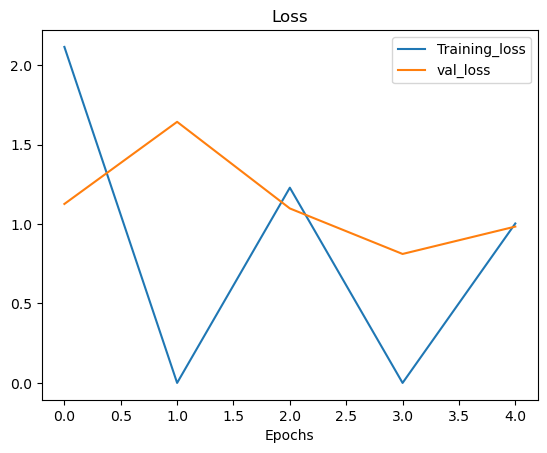

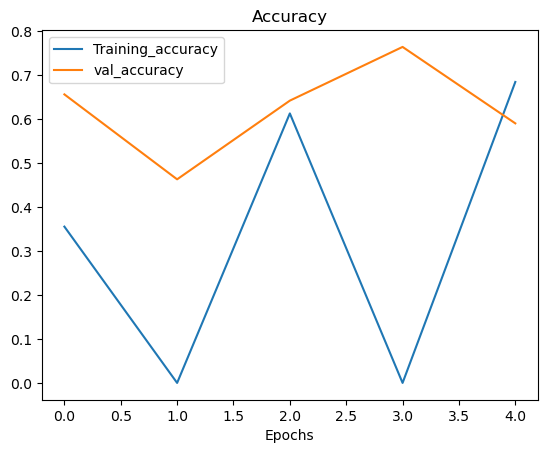

In [39]:
plot_loss_curves (history_1)

### Model_2: 
**Building our EfficientNetB3 Feature Extraction (with 3 Dense layer 560-320-200 unit) with Data Augmentation and 100% of data**

In [70]:
# Setup the input shape, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB3 (include_top = False)
base_model.trainable = False

# Create an input layer
input_layer = tf.keras.layers.Input (shape = input_shape, name = "input_layer")

# Adding data augmentation as a layer to augment our images
#x = data_augmentation_layer (input_layer)

# Give base_model the inputs (after augmetation) and don't train it
x = base_model (input_layer, training = False)

# Pool output features of the base model (to get a feature vector)
x = tf.keras.layers.GlobalAveragePooling2D (name = "global_average_pooling") (x)

## creating the output Dense classifier layer
x = tf.keras.layers.Dense (560, activation = "relu", name = "fully_connected_1") (x)
x = tf.keras.layers.Dense (320, activation = "relu", name = "fully_connected_2") (x)
output_layer = tf.keras.layers.Dense (18, activation = "softmax", name = "output_layer") (x)

# creating our model_2
model_2 = tf.keras.Model (input_layer, output_layer)
model_2.summary ()

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_1 (Dense)            │ (None, 560)                 │         860,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fully_connected_2 (Dense)            │ (None, 320)                 │         179,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 18)                  │           5,778 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,829,553 (45.13 MB)

 Trainable params: 1,046,018 (3.99 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [71]:
# compiling our model
model_2.compile (loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam (learning_rate = 0.001), metrics = ["accuracy"])

# fitting our model and validate with 25% valid data
history_2 = model_2.fit (train_data, steps_per_epoch = len (train_data) // 32, epochs = 20,
                         validation_data = valid_data, validation_steps = int (len (valid_data) * 0.25))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - accuracy: 0.1316 - loss: 2.8297 - val_accuracy: 0.2784 - val_loss: 2.6807
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.3141 - loss: 2.3695 - val_accuracy: 0.5483 - val_loss: 1.6357
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.4080 - loss: 1.9755 - val_accuracy: 0.4972 - val_loss: 1.6819
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 7s/step - accuracy: 0.4515 - loss: 1.8245 - val_accuracy: 0.7017 - val_loss: 0.9987
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6618 - loss: 1.3323 - val_accuracy: 0.2651 - val_loss: 1.8358
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.6523 - loss: 1.2239 - val_accuracy: 0.6875 - val_loss: 1.0584
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.6062 - loss: 1.3323 - val_accuracy: 0.7642 - val_loss: 0.8121
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.5853 - loss: 1.1528 - val_accuracy: 0.6023 - val_loss: 1.2330
Epoch 9/

In [72]:
# evaluating our model_1
model_2.evaluate (valid_data)

47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7653 - loss: 0.7901


[0.7693293690681458, 0.7699530720710754]

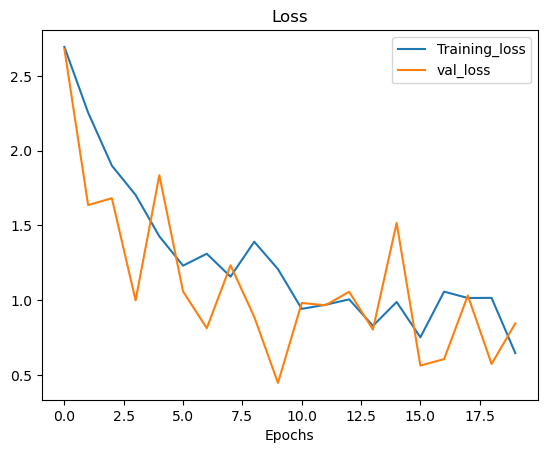

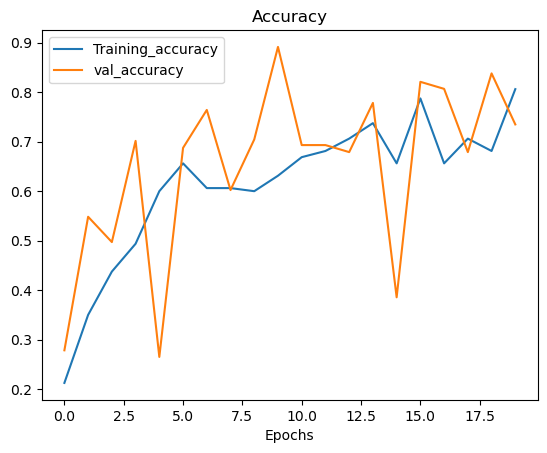

In [73]:
plot_loss_curves (history_2)

In [33]:
y_pred = model_2.predict (valid_data).argmax (axis=1)
y_pred[:10]

47/47 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 14], dtype=int64)

In [34]:
# to get our original test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in valid_data.unbatch ():
    y_label = labels.numpy ().argmax ()# currently test labels looks like: [0, 0, 0, 0, 1, ....] we want the index where the "1" occurs
    y_labels.append (y_label)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
from sklearn.metrics import confusion_matrix

In [44]:
conf_matrix = confusion_matrix (y_labels, y_pred)

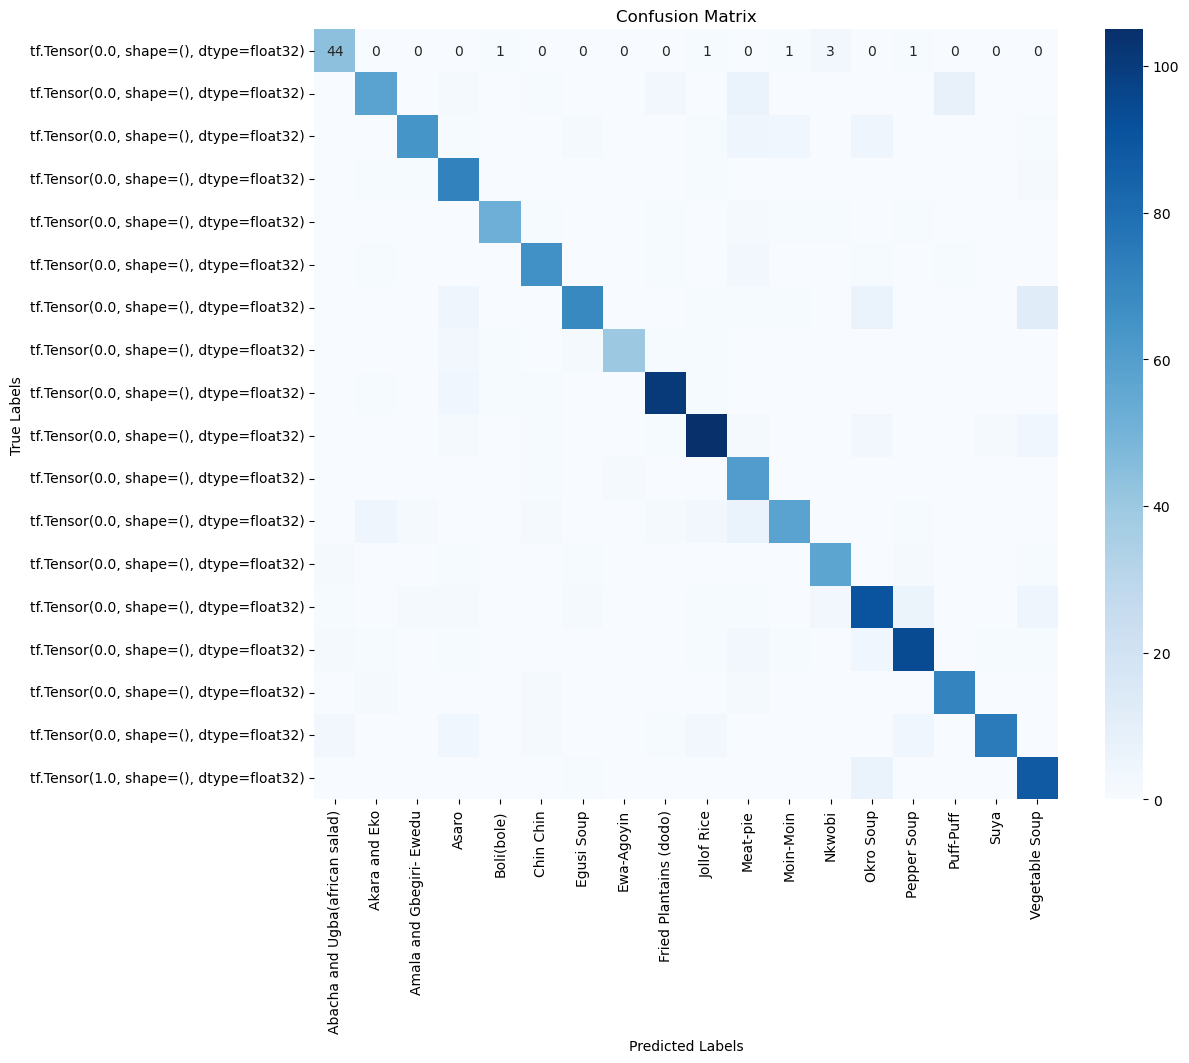

In [45]:
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### Saving our model

In [100]:
model_2.save ("efficientNetB3.h5")

## Fine-tuning our model
**Note:** fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

In [142]:
# load in saved model_2 feature extractor weights and continue training from that point
model_2.load_weights (checkpoint_path)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 15 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [143]:
# Checking if the layers are trainable
for layer in model_2.layers:
    print (layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Functional name=efficientnetb3, built=True> True
<GlobalAveragePooling2D name=global_average_pooling, built=True> True
<Dense name=fully_connected_1, built=True> True
<Dense name=fully_connected_2, built=True> True
<Dense name=output_layer, built=True> True


In [144]:
# what layer are in our model_2 base_model (EfficientNetB0) and are they trainable
for i, layer in enumerate (model_2.layers[1].layers):
    print (i, layer.name, layer.trainable)

0 input_layer_21 False
1 rescaling_40 False
2 normalization_20 False
3 rescaling_41 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block

In [145]:
# How many trainable variables are in our base model
print (len(model_2.layers[1].trainable_variables))

28


In [146]:
# To begin fine-tuning, let's start by setting the last 30 layers of our base model.trainable = True
base_model.trainable = True

# freeze all layers except for the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [147]:
# How many trainable variables are now in our base model
print (len(model_2.layers[1].trainable_variables))

28


In [148]:
# what layer are in our model_2 base_model (EfficientNetB0) and are they now trainable
for i, layer in enumerate (model_2.layers[1].layers):
    print (i, layer.name, layer.trainable)

0 input_layer_21 False
1 rescaling_40 False
2 normalization_20 False
3 rescaling_41 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block

In [149]:
# Recompiling (we have to recompile our models everytime we make a change)
model_2.compile (loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam (learning_rate = 0.0001),    # when fine-tuning you typically want to lower the learning rate by 10x (from 0.001 --> 0.0001)
                 metrics = ["accuracy"]
                )

**Note:** when using fine-turning it's best practice to lower your learning rate by some amount (to reduce the rate at which your trainable parameters get's updated).

How much? this is a hyperparameter you can tune. But a good rule of thumb is at least **10x** (though other sources will claim other values)  

A good resources for information on this is the **ULMFIT paper**

In [31]:
from keras.models import load_model
import tensorflow as tf

In [32]:
model_2 = load_model ("nigeria_food_model_efficientNetB3.h5")

In [7]:
img = tf.io.read_file("food_1.jpg")
img = tf.image.decode_image (img)
img = tf.image.resize (img, (224, 224))
img.shape 

TensorShape([224, 224, 3])

In [13]:
pred = model_2.predict (tf.expand_dims (img, axis = 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [15]:
pred.argmax ()

4